# Central Park Temperature Analysis

In this time-series analysis project, I work with the average monthly temperature data for Central Park in NYC between the years 1870 and 2023 to predict the average temperatures for the remainder of 2024.

The project is divided into the following steps:
#### 1) Examining trends in the data using:
    - Seasonal Decomposition
    - Simple Moving Average
    - Exponentially Weighted Moving Average
    - Double Exponential Smoothing
    - Triple Exponential Smoothing
    
#### 2) Assessing the nature of the data using:
    - ACF and PACF plots
    - the Dickey-Fuller test
    
#### 3) Modeling the data and Forecasting using:
    - Pdarima
    - SARIMA modeling



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import warnings
warnings.filterwarnings('ignore')

import tabula

from pandas.plotting import lag_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

from pmdarima import auto_arima


In [6]:
url = 'https://www.weather.gov/media/okx/Climate/CentralPark/monthlyannualtemp.pdf'

res = requests.get(url)

if res.status_code == 200:
    with open('monthlyannualtemp.pdf', 'wb') as file:
        file.write(res.content)
    print("PDF downloaded")
else:
    print(f"Failed to download PDF. Status code: {response.status_code}")
    

PDF downloaded


In [99]:
pdf_path = '../Downloads/monthlyannualtemp.pdf'

# pip install tabula-py if tabula isnt already installed

import tabula

tabula.convert_into(pdf_path, "CentralParkTemps.csv", output_format="csv", pages='all')


In [663]:
file_path = '../Desktop/CentralParkTemps.csv'

df = pd.read_csv(file_path, index_col = 'Year')

df.head() 

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
Year,,,,,,,,,,,,,
1870,37.5,31.3,34.1,50.7,60.9,72.9,76.6,75.3,67.6,56.7,45.5,34.1,53.6
1871,28.3,30.2,44.2,52,60.4,68.2,72.3,73.6,60.8,55.6,38.8,29.2,51.1
1872,28.8,29.9,30.5,49.4,61.5,71.2,77.5,75.6,66.4,53.2,41.0,26.7,51.0
1873,28.6,29.5,35.7,46.7,58.8,70.3,75.4,72.0,66.4,53.2,41.0,26.7,51.0
1874,34.2,31.3,37.1,41.1,58.8,70.1,73.9,70.3,67.0,55.1,43.4,33.8,51.3


### Next, let's:
 1) drop unnecessary columns
 2) drop null values, and 
 3) melt the month columns into the index to have a single temperature column 

In [664]:
df = df.drop(columns=['Annual'],axis=1)

In [665]:
df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1870,37.5,31.3,34.1,50.7,60.9,72.9,76.6,75.3,67.6,56.7,45.5,34.1
1871,28.3,30.2,44.2,52,60.4,68.2,72.3,73.6,60.8,55.6,38.8,29.2
1872,28.8,29.9,30.5,49.4,61.5,71.2,77.5,75.6,66.4,53.2,41.0,26.7
1873,28.6,29.5,35.7,46.7,58.8,70.3,75.4,72.0,66.4,53.2,41.0,26.7
1874,34.2,31.3,37.1,41.1,58.8,70.1,73.9,70.3,67.0,55.1,43.4,33.8


In [666]:
df.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2020,39.1,40.1,48.0,50.4,60.3,73.7,80.0,76.9,68.8,57.9,53.0,39.2
2021,34.8,34.2,45.8,54.6,62.9,74.3,76.0,77.5,70.3,62.0,46.2,43.8
2022,30.3,37.3,45.3,52.8,64.0,71.4,79.5,79.3,69.5,56.9,50.9,38.5
2023,43.5,41.1,44.6,57.6,62.7,70.0,79.0,75.0,69.4,60.5,46.7,44.6
2024,37,40.1,48.1,55.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [668]:
df = df.dropna()

df.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,32.5,36.2,41.7,55.5,62.2,71.7,79.6,75.5,70.4,59.9,43.9,38.3
2020,39.1,40.1,48.0,50.4,60.3,73.7,80.0,76.9,68.8,57.9,53.0,39.2
2021,34.8,34.2,45.8,54.6,62.9,74.3,76.0,77.5,70.3,62.0,46.2,43.8
2022,30.3,37.3,45.3,52.8,64.0,71.4,79.5,79.3,69.5,56.9,50.9,38.5
2023,43.5,41.1,44.6,57.6,62.7,70.0,79.0,75.0,69.4,60.5,46.7,44.6


In [669]:
# Let's further adjust the dataframe

temps_df = df.reset_index().melt(id_vars='Year',
                                var_name='Month',
                                value_name='Average Temp')

temps_df['Date'] = pd.to_datetime(temps_df['Year'].astype(str) + '-' + temps_df['Month'],
                                 format='%Y-%b')

temps_df = temps_df[['Date','Average Temp']].set_index('Date')
temps_df = temps_df.sort_index()

temps_df.index.freq = 'MS'


In [670]:
temps_df.tail()

,Average Temp
Date,
2023-08-01,75.0
2023-09-01,69.4
2023-10-01,60.5
2023-11-01,46.7
2023-12-01,44.6


### Let's plot the data

In [671]:
# Check if our data is in the correct format

temps_df.index

DatetimeIndex(['1870-01-01', '1870-02-01', '1870-03-01', '1870-04-01',
               '1870-05-01', '1870-06-01', '1870-07-01', '1870-08-01',
               '1870-09-01', '1870-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=1848, freq='MS')

In [672]:
temps_df.info()

# Average Temp is not a float

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1848 entries, 1870-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Average Temp  1848 non-null   object
dtypes: object(1)
memory usage: 28.9+ KB


In [673]:
# Change the Average Temp data into float

temps_df['Average Temp'] = temps_df['Average Temp'].astype(float)

In [674]:
temps_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1848 entries, 1870-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Average Temp  1848 non-null   float64
dtypes: float64(1)
memory usage: 28.9 KB


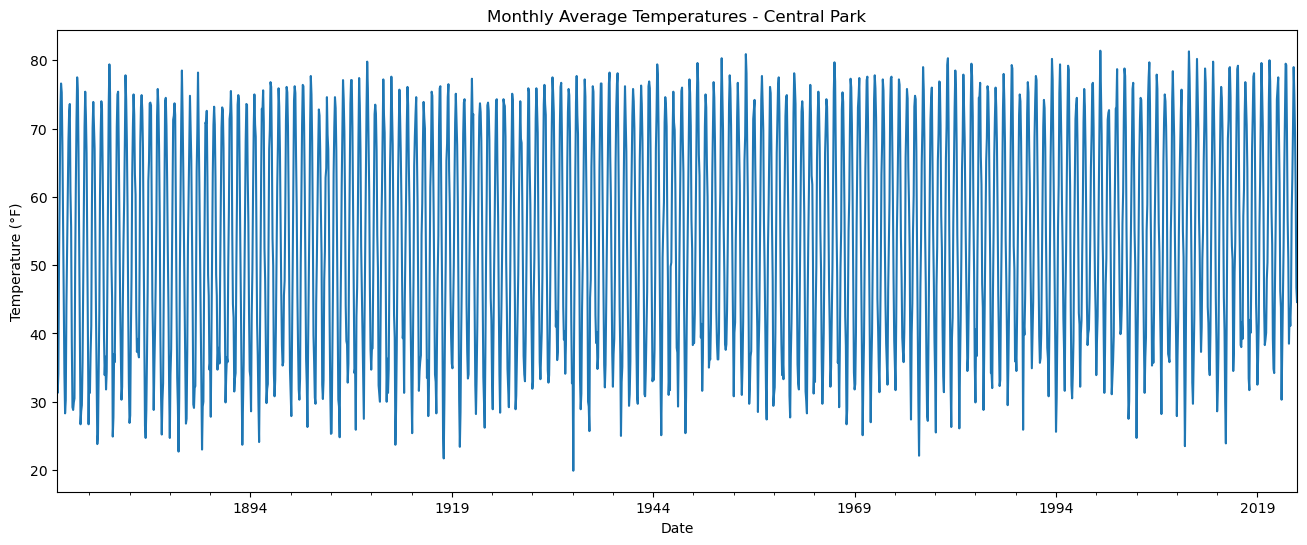

In [724]:
# Now that everything is in order, we are ready to plot

temps_df['Average Temp'].plot(title="Monthly Average Temperatures - Central Park",figsize=(16,6));
plt.ylabel('Temperature (°F)');


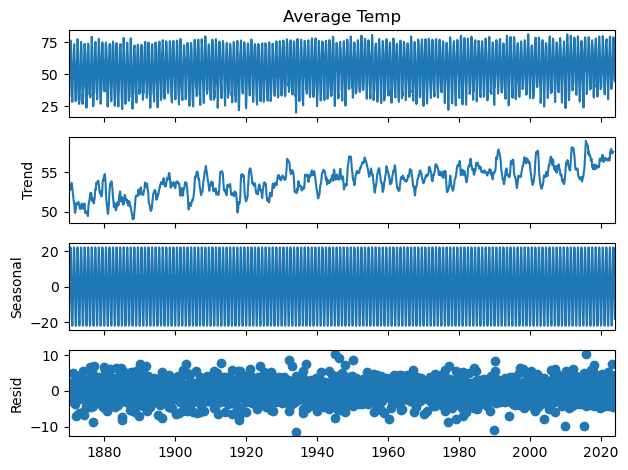

In [676]:
seasonal_decompose(temps_df['Average Temp'],model='add').plot();

## Calculating Simple Moving Average (SMA) and Exponentially Weighted Moving Average (EWMA)

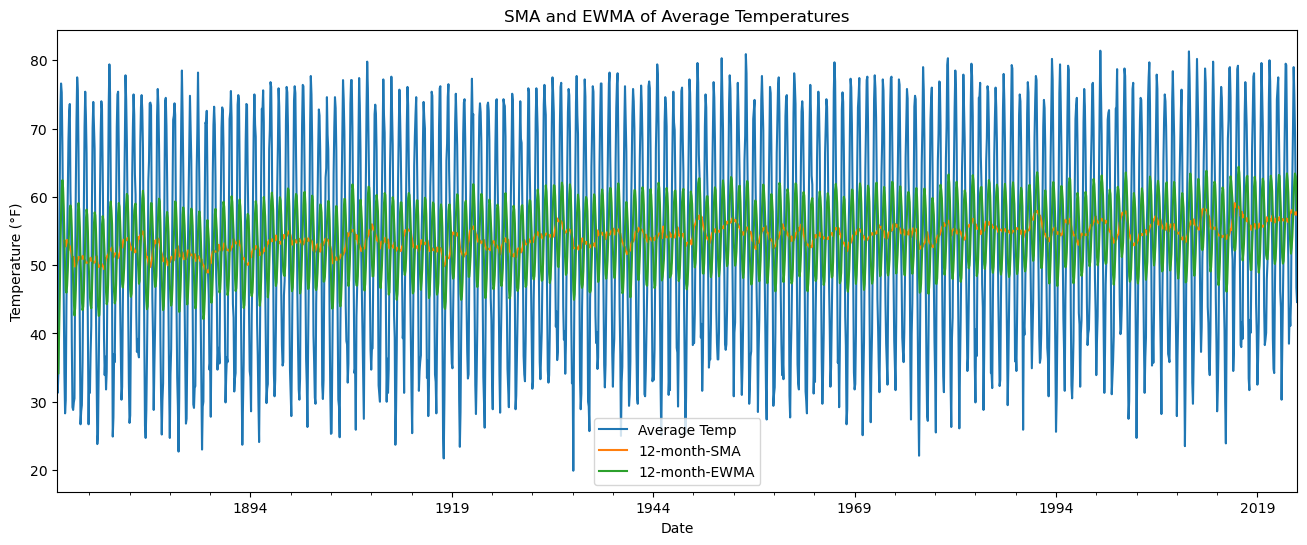

In [727]:
# Both calculated over 12 months

temps_df['12-month-SMA'] = temps_df['Average Temp'].rolling(window=12).mean()
temps_df['12-month-EWMA'] = temps_df['Average Temp'].ewm(span=12).mean()

temps_df[['Average Temp', '12-month-SMA', '12-month-EWMA']].plot(figsize=(16,6));
plt.title("SMA and EWMA of Average Temperatures");
plt.ylabel('Temperature (°F)');


## Analysis using Double Exponential Smoothing

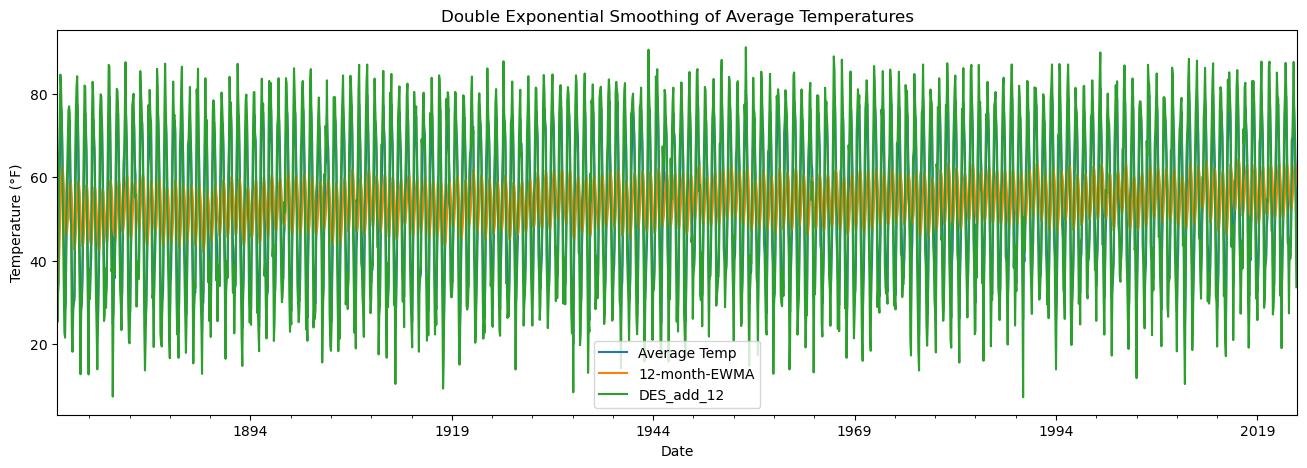

In [728]:
temps_df['DES_add_12'] = ExponentialSmoothing(temps_df['Average Temp'],
                                trend='add').fit().fittedvalues.shift(-1)

temps_df[['Average Temp', '12-month-EWMA','DES_add_12']].plot(figsize=(16,5));
plt.title("Double Exponential Smoothing of Average Temperatures");
plt.ylabel('Temperature (°F)');

## Triple Exponential Smoothing

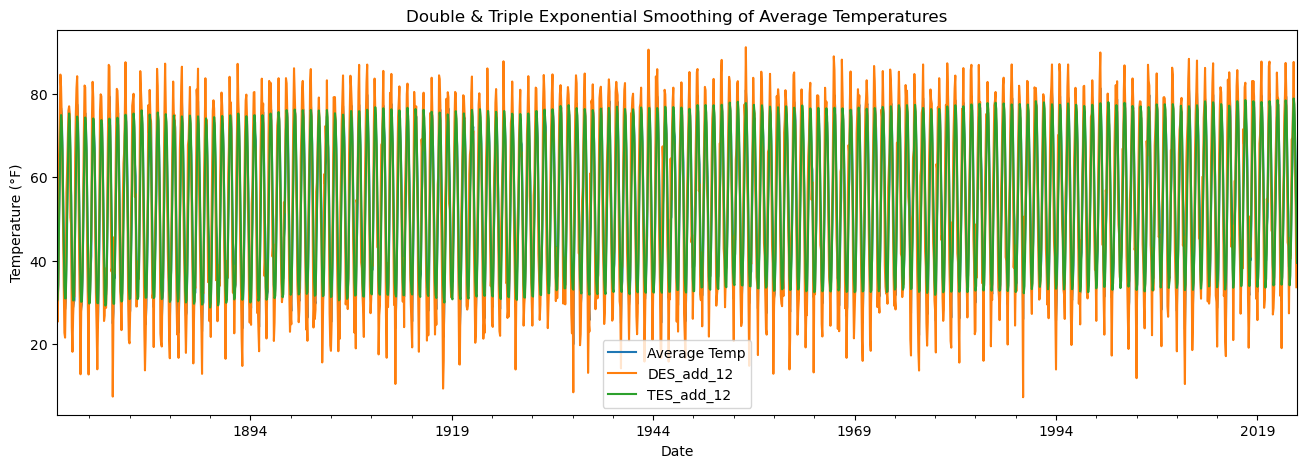

In [729]:
temps_df['TES_add_12'] = ExponentialSmoothing(temps_df['Average Temp'],
                        trend='add',
                        seasonal='add',
                        seasonal_periods=12).fit().fittedvalues

# No need to plot EWMA, since DES fits far better
temps_df[['Average Temp','DES_add_12','TES_add_12']].plot(figsize=(16,5));
plt.title("Double & Triple Exponential Smoothing of Average Temperatures");
plt.ylabel('Temperature (°F)');


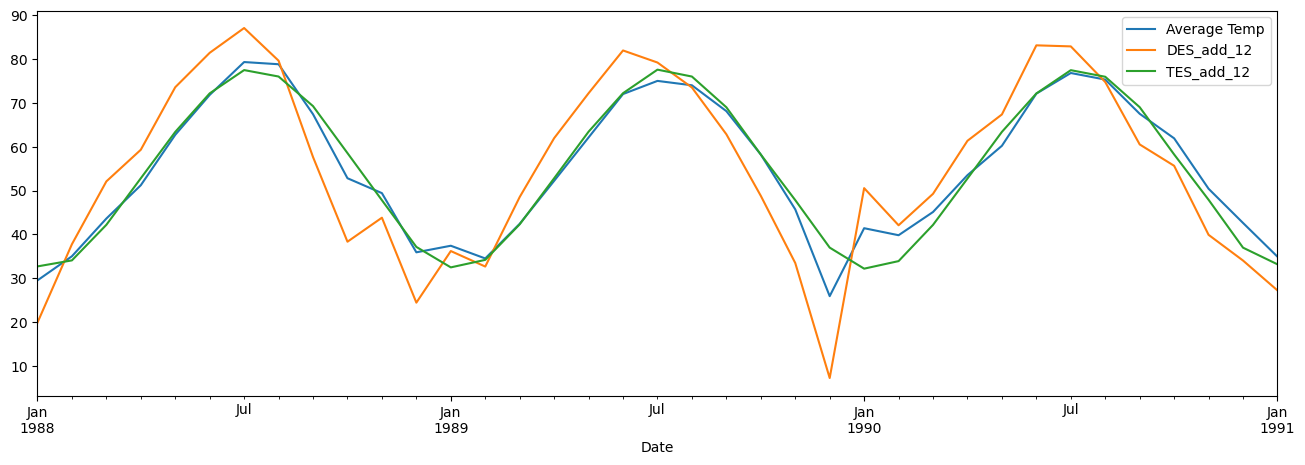

In [683]:
# Taking a closer look

temps_df[['Average Temp', 'DES_add_12','TES_add_12']].loc['1988-01-01':'1991-01-01'].plot(figsize=(16,5));

As we can see, triple exponential smoothing using Holt-Winters fits the model more precisely than double exponential smoothing, or using an exponential weighted moving average (EWMA)



This dataset also appears stationary

## Continuing analysis using ACF and PACF plots

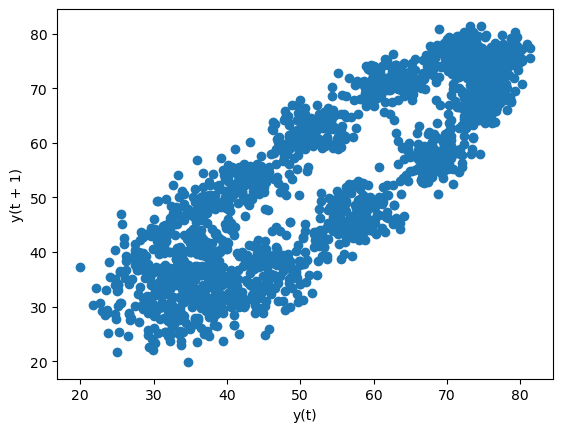

In [730]:
lag_plot(temps_df['Average Temp']);

In [686]:
acf(temps_df['Average Temp']).round(2)

# After reaching 0 at lag 4, the data appears to flip

array([ 1.  ,  0.84,  0.49,  0.01, -0.47, -0.82, -0.95, -0.82, -0.47,
        0.01,  0.48,  0.83,  0.96,  0.83,  0.48,  0.01, -0.47, -0.82,
       -0.94, -0.81, -0.47,  0.01,  0.48,  0.83,  0.95,  0.83,  0.48,
        0.01, -0.46, -0.81, -0.94, -0.81, -0.46])

In [687]:
pacf(temps_df['Average Temp']).round(2)

# pacf becomes negative suddenly at lag 2

array([ 1.  ,  0.84, -0.78, -0.59, -0.44, -0.35, -0.1 ,  0.05,  0.16,
        0.23,  0.26,  0.25,  0.21,  0.08,  0.01, -0.05, -0.09, -0.1 ,
       -0.07, -0.  ,  0.02,  0.06,  0.12,  0.12,  0.12,  0.13,  0.08,
       -0.01,  0.01, -0.04, -0.05, -0.05,  0.  ])

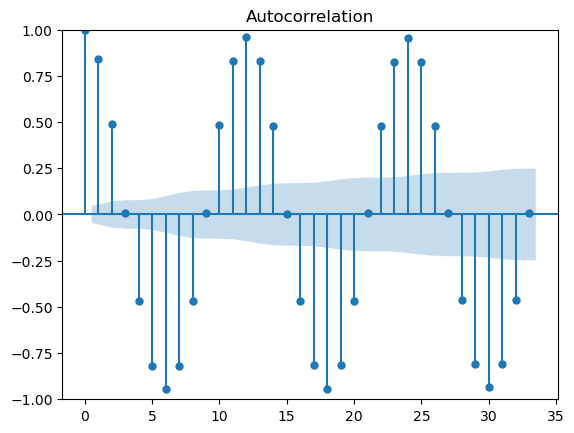

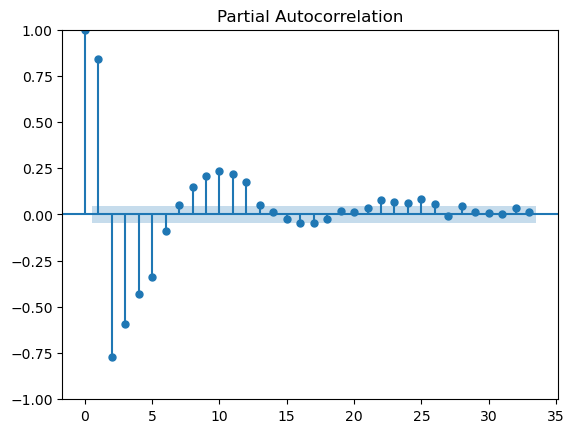

In [731]:
plot_acf(temps_df['Average Temp']);
plot_pacf(temps_df['Average Temp']);

Because of the strong sinusoidal pattern in the ACF, there may not need to be a need to difference at all. However, we can try to difference by 12 (for 12 months), and by 1 (minimal differencing) to see what happens to the plots.

In [690]:
temps_diff = temps_df['Average Temp'].diff(12)  

# Seasonal differencing by 12 months


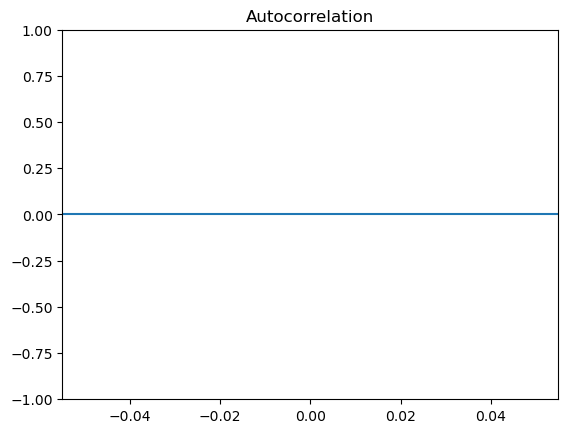

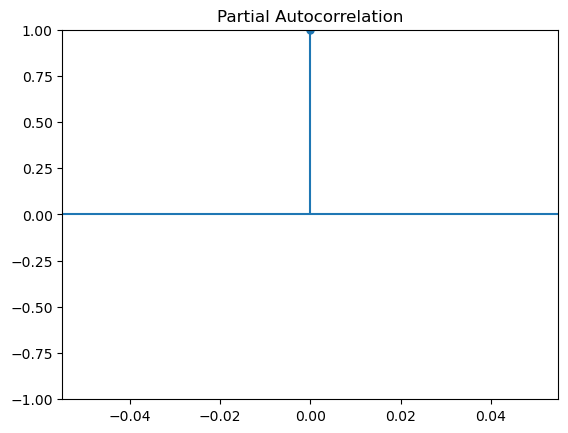

In [691]:
plot_acf(temps_diff,lags=12);
plot_pacf(temps_diff,lags=12);

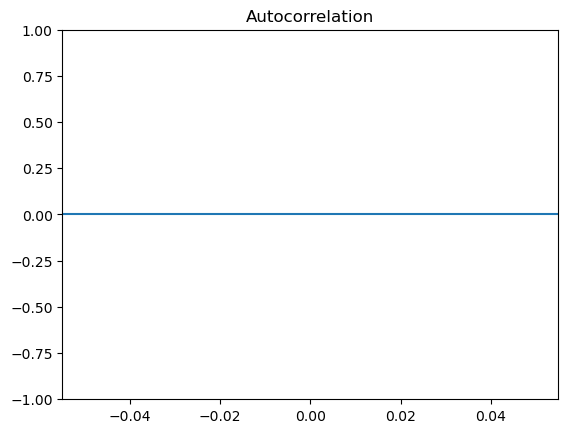

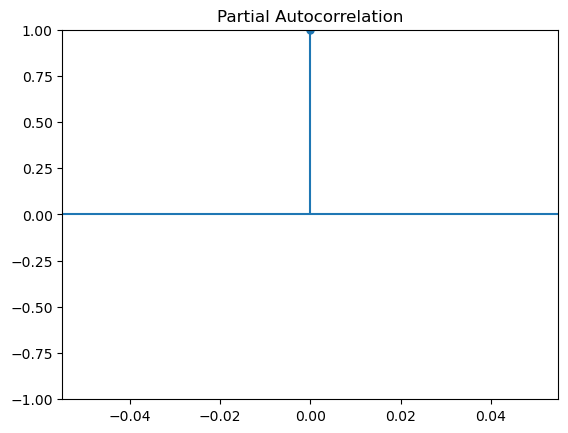

In [692]:
temps_diff = temps_df['Average Temp'].diff(1)  

# Seasonal differencing by 1

plot_acf(temps_diff,lags=1);
plot_pacf(temps_diff,lags=1);

Given these results, we can assume very strong seasonality and stationarity to the model which does not necessarily require a d or D value.

## Checking the degree of stationarity with a Dickey-Fuller test

In [738]:
# Dickey-Fuller function 

def adf_test(series):

    print(f'Augmented Dickey-Fuller Test')
    
    result = adfuller(series.dropna(),autolag='AIC') 
    labels = ['ADF test statistic','p-value','number of lags used','number of observations']
    output = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        output[f'critical value ({key})']=val
    
    print(output)          
    
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is non-stationary")
        

In [739]:
adf_test(temps_df['Average Temp'])

Augmented Dickey-Fuller Test
ADF test statistic          -3.343493
p-value                      0.013043
number of lags used         25.000000
number of observations    1822.000000
critical value (1%)         -3.433944
critical value (5%)         -2.863128
critical value (10%)        -2.567615
dtype: float64
The data is stationary


**Given this result, we can reject the null hypothesis and treat it as a stationary dataset with strong seasonality**

## Fitting the data to a model

In [695]:
auto_arima(temps_df['Average Temp'], seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1848
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -4696.161
Date:                Sat, 28 Sep 2024   AIC                           9412.322
Time:                        09:59:34   BIC                           9467.536
Sample:                    01-01-1870   HQIC                          9432.677
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9712      0.054     18.085      0.000       0.866       1.076
ar.L2          0.5190      0.096      5.392      0.000       0.330       0.708
ar.L3         -1.1228      0.064    -17.657      0.000      -1.247      -0.998
ar.L4          0.2245      0.032      6.936      0.000       0.161       0.288
ar.L5         -0.0126      0.027     -0.474      0.635      -0.065       0.039
ma.L1         -1.6840      0.049    -34.430      0.000      -1.780      -1.588
ma.L2          0.0091      0.128      0.071      0.943      -0.241       0.259
ma.L3          1.5974      0.125     12.733      0.000       1.352       1.843
ma.L4         -0.9134      0.047    -19.527      0.000      -1.005      -0.822
sigma2         9.9719      0.301     33.116      0.000       9.382      10.562
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                63.59
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.12
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**In spite of our Dicket-Fuller test, pandas determined the model would have a better fit with a d=1.**

## Split data into train and test sets, and train the model

In [697]:
# Check the length to create the train and test sets

len(temps_df)

1848

In [710]:
train = temps_df.iloc[:1836]
test = temps_df.iloc[1836:]

results = SARIMAX(train['Average Temp'], order=(5,1,4)).fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45058D+00    |proj g|=  1.46857D+00

At iterate    5    f=  2.78617D+00    |proj g|=  2.04808D-01

At iterate   10    f=  2.68136D+00    |proj g|=  5.67413D-02

At iterate   15    f=  2.66002D+00    |proj g|=  1.79209D-01

At iterate   20    f=  2.65786D+00    |proj g|=  3.22256D-02

At iterate   25    f=  2.65583D+00    |proj g|=  1.18826D-01

At iterate   30    f=  2.64909D+00    |proj g|=  3.93023D-01

At iterate   35    f=  2.63274D+00    |proj g|=  1.65877D-01

At iterate   40    f=  2.60598D+00    |proj g|=  9.74877D-01

At iterate   45    f=  2.57839D+00    |proj g|=  2.67543D-01

At iterate   50    f=  2.56521D+00    |proj g|=  7.44096D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Average Temp   No. Observations:                 1836
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -4709.720
Date:                Sat, 28 Sep 2024   AIC                           9439.441
Time:                        10:02:58   BIC                           9494.589
Sample:                    01-01-1870   HQIC                          9459.778
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9663      0.115      8.414      0.000       0.741       1.191
ar.L2          0.4782      0.221      2.168      0.030       0.046       0.911
ar.L3         -1.0768      0.167     -6.431      0.000      -1.405      -0.749
ar.L4          0.2370      0.054      4.419      0.000       0.132       0.342
ar.L5         -0.0477      0.027     -1.781      0.075      -0.100       0.005
ma.L1         -1.6729      0.112    -14.888      0.000      -1.893      -1.453
ma.L2          0.0145      0.295      0.049      0.961      -0.565       0.594
ma.L3          1.5889      0.289      5.498      0.000       1.022       2.155
ma.L4         -0.9196      0.105     -8.745      0.000      -1.126      -0.713
sigma2         9.8226      0.292     33.695      0.000       9.251      10.394
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                56.87
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [711]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start,end).rename('SARIMAX (5,1,4) Predictions')

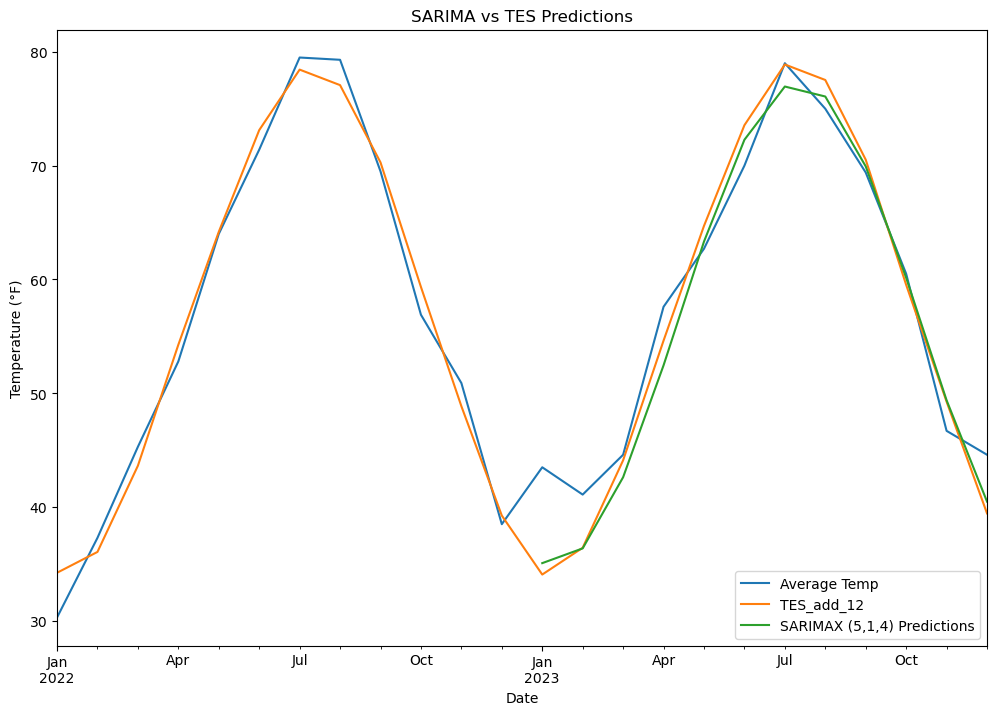

In [740]:
temps_df['Average Temp'].iloc[1824:].plot(legend=True,figsize=(12,8));
temps_df['TES_add_12'].iloc[1824:].plot(legend=True);
predictions.plot(legend=True);
plt.title("SARIMA vs TES Predictions")
plt.ylabel('Temperature (°F)');

### Test the goodness of fit using root mean square error (RMSE)

In [713]:
from statsmodels.tools.eval_measures import rmse

In [714]:
error_SARIMA = rmse(test['Average Temp'], predictions)
error_TES = rmse(test['Average Temp'], temps_df['TES_add_12'].iloc[1836:])

print(error_SARIMA)
print(error_TES)

3.6413282563138707
3.852275016852866


In [715]:
temps_df['Average Temp'].std()

16.10578675679602

The rmse of the SARIMA predictions (3.28) is lower than that of the TES (3.97), so we can assume it is a better fit for the data than TES. Also, the SARIMA rmse is quite low compared to the std of the dataset (16.11). Therefore, this model is appropriate for forecasting the average temperature 12 months ahead.

# Forecasting into the future

In [716]:
model = SARIMAX(temps_df['Average Temp'], order=(5,1,4))
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44122D+00    |proj g|=  1.43323D+00

At iterate    5    f=  2.78636D+00    |proj g|=  2.02646D-01

At iterate   10    f=  2.68187D+00    |proj g|=  4.42854D-02

At iterate   15    f=  2.65951D+00    |proj g|=  2.61551D-02

At iterate   20    f=  2.65728D+00    |proj g|=  1.91915D-02

At iterate   25    f=  2.64860D+00    |proj g|=  2.30523D-01

At iterate   30    f=  2.62660D+00    |proj g|=  1.13554D-01

At iterate   35    f=  2.59830D+00    |proj g|=  1.72854D-01

At iterate   40    f=  2.55671D+00    |proj g|=  6.49951D-01

At iterate   45    f=  2.55405D+00    |proj g|=  1.90493D-01

At iterate   50    f=  2.54121D+00    |proj g|=  1.14035D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

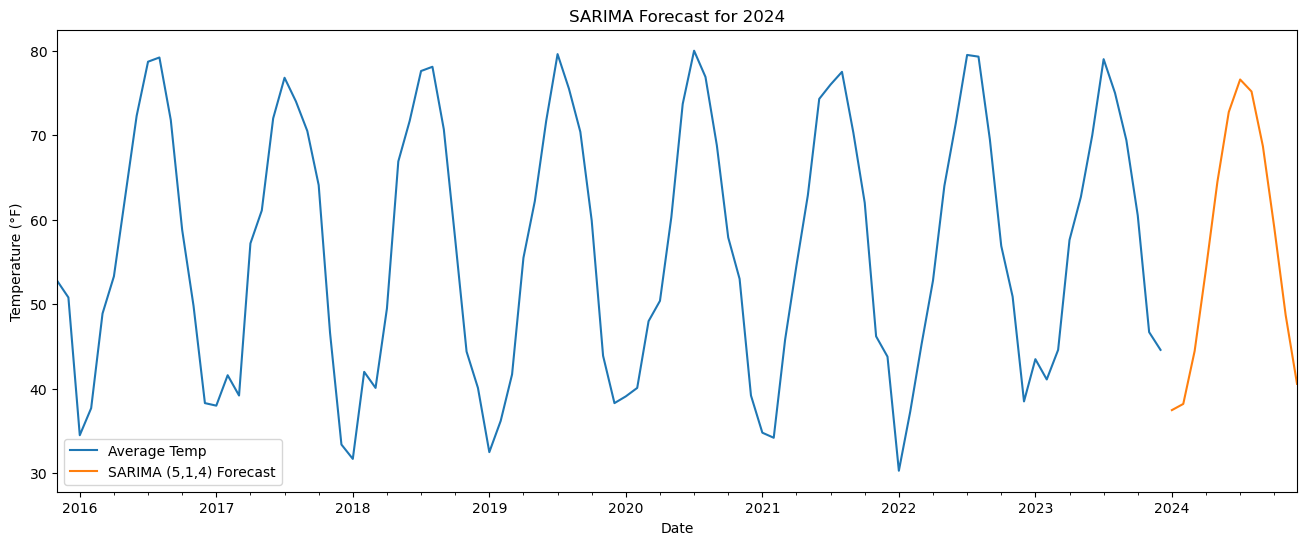

In [737]:
fcast = results.predict(start=len(temps_df),
                    end=len(temps_df)+11,
                    typ='levels').rename('SARIMA (5,1,4) Forecast')

temps_df['Average Temp'].iloc[1750:].plot(legend=True, figsize=(16,6));
fcast.plot(legend=True);
plt.title("SARIMA Forecast for 2024")
plt.ylabel('Temperature (°F)');


**It seems that, due to the noise from the constant seasonal oscillation, the model did not pick up on the rising average temperature which was apparent in the seasonal decomposition**

However, the model fit the data quite well so this would imply that the prediction is reasonable.